In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
import seaborn as sns 

In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [124]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    trainAvgLossArr = []
    trainAvgAccArr = []
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #print(epoch,i)
            
            #Weight Collection
            if epoch % 3 == 0:
                for name, parameter in model.named_parameters():
                    #print(name)
                    if'weight' in name:
                        modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                        print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        # #Weight Collection
        # for name, parameter in model.named_parameters():
        #     #print(name)
        #     if'weight' in name:
        #         modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
        #         print(modelParamWgt)       
                        
        epochLoss = lossSum/(i+1)
        epochAcc = totalacc/(i+1)
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt

In [125]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [126]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [127]:
#2nd Approach

max_epochs = 15
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 100
test_batch_size = 100
status_interval = 50
loss_func = nn.CrossEntropyLoss()

for count in range(8):
    print("Time: "+str(count))
    M = Model()
    optimizer = torch.optim.Adam(M.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times: "+str(count)    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(M,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(M,loss_func,test_batch_size)

    temp_df = pd.DataFrame(modelParamWgt).transpose()
    all_df = all_df.append(temp_df)
    

    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr





Time: 0
strated
{3: array([ 0.06618412, -0.12359316,  0.08577335,  0.07603326, -0.32165042,
        0.12012471,  0.17183119, -0.07122995, -0.0679654 , -0.17861488,
        0.2680569 ,  0.28226703,  0.23923251,  0.20502853,  0.26176295,
        0.09305441,  0.17011355,  0.2799061 ,  0.06426622, -0.0266142 ,
       -0.09029788, -0.12483963,  0.21391152,  0.00719188,  0.16593464,
        0.13717392,  0.26171207, -0.05011383,  0.03609629,  0.11114879,
        0.00634471,  0.30868182,  0.12926137,  0.16071516,  0.15238403,
        0.2497622 ,  0.2837394 ,  0.27066547,  0.04974047,  0.07585196,
       -0.05227539,  0.15956473,  0.22433157, -0.13679172, -0.13663584,
        0.06522839, -0.05014652,  0.00624137, -0.0168136 , -0.14808767,
       -0.23876527, -0.21665443,  0.20174184, -0.01153608,  0.03343857,
       -0.304186  , -0.00422193,  0.1441897 ,  0.0648794 ,  0.28134626,
       -0.2959177 , -0.18774617,  0.15630883,  0.22026765,  0.07304294,
       -0.17802042, -0.16645545,  0.25888368

In [ ]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [ ]:
np.shape(trainAccArr)

(8, 15)

In [ ]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(120,) & Shape of Acc: (120,)


In [ ]:
t1 = all_df
print(pd.DataFrame(t1))

        0             1         2             3         4             5     \
1  -0.052444 -7.037309e-10 -0.078028 -9.602345e-02 -0.012989 -1.081708e-01   
2  -0.050667 -8.188808e-18 -0.067190 -9.471924e-02  0.005740 -1.089787e-01   
3  -0.055816  5.054739e-09 -0.064637 -9.618087e-02  0.004586 -1.120372e-01   
4  -0.056235  9.558672e-04 -0.060027 -9.611767e-02  0.003322 -1.204733e-01   
5  -0.058285  3.876412e-05 -0.055835 -9.747330e-02  0.002118 -1.267077e-01   
..       ...           ...       ...           ...       ...           ...   
11 -0.010092 -9.515038e-03  0.007288 -2.299880e-39  0.010782 -1.244944e-22   
12 -0.006206 -9.834007e-03  0.007882 -4.644091e-19  0.009827  1.886069e-36   
13 -0.009509 -9.121754e-03  0.007644 -4.323084e-32  0.008330 -1.376740e-02   
14 -0.003450 -9.566293e-03  0.008531  8.909454e-16  0.009392 -1.179393e-02   
15 -0.003194 -9.494048e-03  0.009287  5.516469e-03  0.006325 -9.568937e-03   

        6             7             8         9     ...      11

In [ ]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['eps']=eps_each_time
allEpochDf['time']=times
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


x         y  eps  time        Acc      Loss
0   -0.437580  1.878003    0     0  70.871323  0.524284
1   -0.464636  2.039330    1     0  95.711622  0.135408
2   -0.480372  2.151832    2     0  96.918950  0.096183
3   -0.497489  2.246467    3     0  97.615159  0.077482
4   -0.512109  2.335002    4     0  97.876021  0.066540
..        ...       ...  ...   ...        ...       ...
115  0.497089 -0.490873   10     7  98.688495  0.038894
116  0.511227 -0.497011   11     7  99.012964  0.036212
117  0.519778 -0.500400   12     7  98.946471  0.034048
118  0.532884 -0.504973   13     7  99.076886  0.030849
119  0.542015 -0.508032   14     7  99.171429  0.029220

[120 rows x 6 columns]

In [ ]:
epoch3Df = allEpochDf.loc[(allEpochDf['eps']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

x         y  eps  time        Acc      Loss
0  -0.480372  2.151832    2     0  96.918950  0.096183
1  -0.528758  2.419680    5     0  98.290697  0.058754
2  -0.567648  2.648606    8     0  98.689311  0.041976
3  -0.596608  2.836193   11     0  99.023346  0.032887
4  -0.620020  2.992002   14     0  99.166411  0.026184
5  -0.620036  0.181848    2     1  96.788257  0.101688
6  -0.719618  0.211320    5     1  98.203477  0.058699
7  -0.795209  0.236351    8     1  98.748401  0.042083
8  -0.856314  0.259843   11     1  98.950955  0.032462
9  -0.912922  0.288479   14     1  99.190581  0.025946
10  1.873435  0.286614    2     2  96.429842  0.108743
11  2.087542  0.344706    5     2  98.031005  0.063481
12  2.255609  0.389825    8     2  98.505671  0.045655
13  2.386494  0.422661   11     2  98.899695  0.035216
14  2.504641  0.449010   14     2  99.087082  0.028581
15 -1.162778  0.272240    2     3  96.785030  0.105508
16 -1.310625  0.289609    5     3  97.982470  0.060580
17 -1.417727  0.302868    8     3  98.639165  0.044660
18 -1.513529  0.314591   11     3  98.950518  0.035424
19 -1.599566  0.328683   14     3  99.134776  0.029383
20  1.310365 -0.304080    2     4  96.408733  0.111007
21  1.464103 -0.352113    5     4  98.008579  0.063818
22  1.576420 -0.372494    8     4  98.560335  0.045783
23  1.673669 -0.383134   11     4  99.004356  0.034492
24  1.763464 -0.398534   14     4  99.183489  0.027587
25 -0.630156 -0.857702    2     5  96.583971  0.109023
26 -0.719510 -0.950392    5     5  98.138632  0.063982
27 -0.785041 -1.024447    8     5  98.617425  0.045707
28 -0.834753 -1.088542   11     5  99.044606  0.034219
29 -0.875504 -1.142482   14     5  99.237991  0.028111
30 -0.609931 -1.386161    2     6  96.671036  0.105070
31 -0.690051 -1.556306    5     6  98.038579  0.061193
32 -0.761641 -1.679672    8     6  98.741871  0.043166
33 -0.829700 -1.775831   11     6  98.957288  0.033564
34 -0.890314 -1.862241   14     6  99.240852  0.026147
35  0.386900 -0.436216    2     7  96.103648  0.119599
36  0.440396 -0.461172    5     7  98.085955  0.063142
37  0.477492 -0.480287    8     7  98.540321  0.045787
38  0.511227 -0.497011   11     7  99.012964  0.036212
39  0.542015 -0.508032   14     7  99.171429  0.029220

In [ ]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))

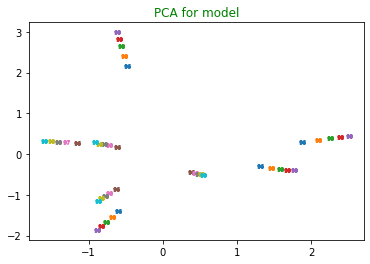

In [ ]:
for i in range(len(mv)):
    m = mv[i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$')
    plt.title("PCA for model",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()